# APS360 Project

The purpose of our model is to detect emotions (Positive, Neutral, Negative) from the given sentence, mainly from Twitter.

## 1. Data Preprocessing:



From the searched dataset, choose the most appropriate sets (e.g. no any missing values, or anything that will misleading the model). First, list the dataset you chose at here. Then, combine the records into one csv file, with the appropriate format. After this, split the data into train/val/test sets with appropriate percentages.

We choose to divide the emotions into mainly three categories: Positive, Negative, Neutral.

1.1 Load the data

Import needed libraries：

In [ ]:
import pandas as pd
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

Mount at google drive：

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


get the dataframe：

In [ ]:
#csv_path='/content/drive/MyDrive/Untitled Folder 1/Copy of project.csv'  # path 0 (Zhijian)
csv_path = '/content/drive/MyDrive/APS360_project/tweet_emotions.csv'  # path 1 (Lynne)
txt_path = '/content/drive/MyDrive/APS360_project/text.txt'
#csv_path = '/content/drive/MyDrive/project.csv'  # path 2 (Yixuan)
df=pd.read_csv(csv_path)

In [ ]:
# Lists to store the data for each column
column1_data = []
column2_data = []

# Read the text file and split it into lines
with open(txt_path, 'r') as file:
    lines = file.readlines()

# Split each line into two columns and store the data
for line in lines:
    column1, column2 = line.strip().split('\t')  # Assuming columns are tab-separated
    column1_data.append(column1)
    column2_data.append(column2)

# Create a dictionary with the column names and data
data = {'column1_name': column1_data, 'column2_name': column2_data}

# Convert the dictionary into a DataFrame
df1 = pd.DataFrame(data)

In [ ]:
len(df)

40000

Clear the labels:

In [ ]:
sentiment_column = 'sentiment'

# Get the unique values in the sentiment column
unique_sentiments = df[sentiment_column].unique()

# Print the unique sentiments
print("Unique Sentiments:")
for sentiment in unique_sentiments:
    print(sentiment)

Unique Sentiments:
empty
sadness
enthusiasm
neutral
worry
surprise
love
fun
hate
happiness
boredom
relief
anger


In [ ]:
# Dictionary of replacements
replacement_dict = {
    'empty': 0,
    'sadness': 1,
    'enthusiasm': 2,
    'neutral': 3,
    'worry': 4,
    'surprise': 5,
    'love': 6,
    'fun': 7,
    'hate': 8,
    'happiness': 9,
    'boredom': 10,
    'relief': 11,
    'anger': 12
}

df['sentiment'] = df['sentiment'].replace(replacement_dict)

In [ ]:
# Dictionary of new column names
new_column_names = {
    'sentiment': 'label',
    'content': 'sentence',
}

# Rename the columns
df.rename(columns=new_column_names, inplace=True)

Visualize part of the data：

In [ ]:
df.head()

,tweet_id,label,sentence
0,1956967341,0,@tiffanylue i know i was listenin to bad habi...
1,1956967666,1,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,1,Funeral ceremony...gloomy friday...
3,1956967789,2,wants to hang out with friends SOON!
4,1956968416,3,@dannycastillo We want to trade with someone w...


Have been combine the needed data into one file.

## 2. Data Transformation:

2.1 Preprocessing the sentence

Load all neeed packages and libraries:

In [ ]:
# import all needed libraries in section 2.1

# packages needed by tokenization
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# packages needed by remove punctuations
import string
# packages needed by co-occurance calc
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Tokenize the sentence by white-space tokenization:

In [ ]:
##### OUR CODE #####
df['sentence'] = df['sentence'].astype(str)  # Convert 'sentence' column to string
df['tokenized_sentences'] = df['sentence'].apply(lambda x: word_tokenize(x))  # New column 'tokenized_sentences' containing tokenized sentences
subdf = df[["label", "tokenized_sentences"]]  # extract the labels and tokenized sentences into a new dataframe, subdf
subdf[:3]  # visualize first three lines of subdf dataframe

,label,tokenized_sentences
0,0,"[@, tiffanylue, i, know, i, was, listenin, to,..."
1,1,"[Layin, n, bed, with, a, headache, ughhhh, ......"
2,1,"[Funeral, ceremony, ..., gloomy, friday, ...]"


Remove the punctuations by manual punctuation removal:

In [ ]:
##### OUR CODE #####
# Function to remove punctuation from a token
def remove_punctuation(token):
    translator = str.maketrans('', '', string.punctuation)
    return token.translate(translator)

# Remove punctuation from the tokens in the 'tokenized_sentences' column
# 'perfect_tokens' column contains tokenized sentences with punctuation removed
subdf['perfect_tokens'] = subdf['tokenized_sentences'].apply(lambda tokens: [remove_punctuation(token) for token in tokens])
# .apply() method is used to apply a function to each element of the 'tokenized_sentences' column
# Lambda func iterates over each token in the list of tokens;
# For each token, it calls the remove_punctuation() func to remove any punctuation from the token;
# Result is a list comprehension that generates a new list of tokens without punctuation

<ipython-input-13-48fb075ceac4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['perfect_tokens'] = subdf['tokenized_sentences'].apply(lambda tokens: [remove_punctuation(token) for token in tokens])


In [ ]:
subdf[13:14]  # print one line to visualize the tokens after remove the punctuations

,label,tokenized_sentences,perfect_tokens
13,1,"[@, BrodyJenner, if, u, watch, the, hills, in,...","[, BrodyJenner, if, u, watch, the, hills, in, ..."


Remove any empty tokens:

In [ ]:
# Remove empty strings from the tokenized sentences
subdf['perfect_tokens'] = subdf['perfect_tokens'].apply(lambda tokens: [token for token in tokens if token])
# For each token, it checks if the token is truthy
# (i.e., not an empty string or None). If the token is truthy, it is included in the resulting list
subdf[13:14]  # print one line to visualize the token after convert to lowercases

<ipython-input-15-68563aa987d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['perfect_tokens'] = subdf['perfect_tokens'].apply(lambda tokens: [token for token in tokens if token])


,label,tokenized_sentences,perfect_tokens
13,1,"[@, BrodyJenner, if, u, watch, the, hills, in,...","[BrodyJenner, if, u, watch, the, hills, in, lo..."


Convert tokens in lowercase:

In [ ]:
##### OUR CODE #####
subdf['perfect_tokens'] = subdf['perfect_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
subdf[13:14]  # print one line to show the lower cases tokens

<ipython-input-16-448ab87c2a76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['perfect_tokens'] = subdf['perfect_tokens'].apply(lambda tokens: [token.lower() for token in tokens])


,label,tokenized_sentences,perfect_tokens
13,1,"[@, BrodyJenner, if, u, watch, the, hills, in,...","[brodyjenner, if, u, watch, the, hills, in, lo..."


Remove empty lines:

In [ ]:
# Remove rows where 'Column1' is empty
subdf = subdf.dropna(subset = ['perfect_tokens'])
subdf = subdf[subdf['perfect_tokens'].apply(lambda x: len(x) > 0)]
subdf[59:66]

,label,tokenized_sentences,perfect_tokens
59,1,"[@, maternitytees, Aww, Onward, and, upwards, ...","[maternitytees, aww, onward, and, upwards, now..."
60,4,"[@, itsgabbith, at, once, haha, ., poor, aby, ...","[itsgabbith, at, once, haha, poor, aby, still,..."
61,1,"[diesel, yaris, ..., 70mpg, so, sad, its, not,...","[diesel, yaris, 70mpg, so, sad, its, not, avai..."
62,1,"[I, want, to, buy, this, great, album, but, un...","[i, want, to, buy, this, great, album, but, un..."
63,1,"[@, Pokinatcha, in, all, honesty, ..., pain, b...","[pokinatcha, in, all, honesty, pain, blech]"
64,1,"[Ok, ..., the, passengers, ..., no, one, is, a...","[ok, the, passengers, no, one, is, alive, they..."
65,3,"[At, home, alone, with, not, much, to, do]","[at, home, alone, with, not, much, to, do]"


Co-occurance calculation:

In [ ]:
# In order to create a loop up table
# Create an empty list to store the frequency dictionaries
frequency_list = []

# Iterate over each row in the DataFrame
for index, row in subdf.iterrows():
    # Get the tokenized sentence from 'perfect_tokens' column
    tokens = row['perfect_tokens']
    # Count the occurrences of each token in the sentence
    token_counts = Counter(tokens)
    # Add the frequency dictionary
    frequency_list.append(token_counts)

# Assign the frequency dictionary to the 'frequency' column
subdf['frequency'] = frequency_list
subdf[:3]

,label,tokenized_sentences,perfect_tokens,frequency
0,1.0,"[im, getting, on, borderlands, and, i, will, m...","[im, getting, on, borderlands, and, i, will, m...","{'im': 1, 'getting': 1, 'on': 1, 'borderlands'..."
1,1.0,"[I, am, coming, to, the, borders, and, I, will...","[i, am, coming, to, the, borders, and, i, will...","{'i': 2, 'am': 1, 'coming': 1, 'to': 1, 'the':..."
2,1.0,"[im, getting, on, borderlands, and, i, will, k...","[im, getting, on, borderlands, and, i, will, k...","{'im': 1, 'getting': 1, 'on': 1, 'borderlands'..."


In [ ]:
subdf['index_token'] = subdf['perfect_tokens'].apply(lambda tokens: {i: token for i, token in enumerate(tokens)})
subdf = subdf[['label', 'perfect_tokens', 'frequency', 'index_token']]
subdf[:3]

,label,perfect_tokens,frequency,index_token
0,1.0,"[im, getting, on, borderlands, and, i, will, m...","{'im': 1, 'getting': 1, 'on': 1, 'borderlands'...","{0: 'im', 1: 'getting', 2: 'on', 3: 'borderlan..."
1,1.0,"[i, am, coming, to, the, borders, and, i, will...","{'i': 2, 'am': 1, 'coming': 1, 'to': 1, 'the':...","{0: 'i', 1: 'am', 2: 'coming', 3: 'to', 4: 'th..."
2,1.0,"[im, getting, on, borderlands, and, i, will, k...","{'im': 1, 'getting': 1, 'on': 1, 'borderlands'...","{0: 'im', 1: 'getting', 2: 'on', 3: 'borderlan..."


Shuffle the subdf dataframe (randomlize it):

In [ ]:
subdf = subdf.sample(frac=1, random_state=42)
subdf

,label,tokenized_sentences,perfect_tokens
32823,3,"[Good, Morning]","[good, morning]"
16298,0,"[I, just, put, my, computer, up, on, craigslis...","[i, just, put, my, computer, up, on, craigslis..."
28505,6,"[in, ten, minutes, shopping, demi, lovato-back...","[in, ten, minutes, shopping, demi, lovatoback,..."
6689,3,"[From, twitterberry, moved, to, ubertwitter, -...","[from, twitterberry, moved, to, ubertwitter, s..."
26893,1,"[@, thriftymom, TEAR, *]","[thriftymom, tear]"
...,...,...,...
6265,3,[Cleaning],[cleaning]
11284,8,"[ooo, my, goddddd, ;, vodafone, trouble, ., no...","[ooo, my, goddddd, vodafone, trouble, no, netw..."
38158,7,"[watching, run, fat, boy, run, ..., haha, its,...","[watching, run, fat, boy, run, haha, its, soo,..."
860,8,"[@, calvinharris, make, the, most, of, pork, p...","[calvinharris, make, the, most, of, pork, prod..."


Summary:

Section 2.1 take in the combined csv file, convert the sentence column from a sentence into word tokens, the final output is the tokens without punctuations and also no empty tokens. Output variable type is a list of strings for the whole column named **perfect_tokens** inside the combined csv file **project.csv**.

2.2 Encode words using GloVe 跑模型，存数据

Load a pre-trained GloVe Model 将找到的模型存入，以便使用

Split each sentence and sequences the vectors:

In [ ]:
# find the length of each list of tokens and the maximum length of them
import pandas as pd

# Calculate the maximum length of the lists and store the lengths in a new column
subdf['list_lengths'] = subdf['perfect_tokens'].apply(len)

# Find the maximum length among all lists
max_length = subdf['list_lengths'].max()

# Print the maximum length and the lengths of each list
print("Maximum length:", max_length)
#print("Lengths of each list:\n", subdf['list_lengths'])

Maximum length: 37


2.3 Dataset Splitting:

In [ ]:
# Import needed libraries and packages
import torch
from torch import nn
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim = 50)

.vector_cache/glove.6B.zip: 862MB [03:40, 3.91MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21999.18it/s]


In [ ]:
vectors = glove.vectors
vocab = glove.stoi
itos = glove.itos

In [ ]:
# Import library
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import Dataset

# Choose the training and validation data
train_file = subdf[0:25000]
val_file = subdf[25000:30000]
train_dic = []
val_dic = []

length_number = 31

for i in range(length_number):
  specific_length_sentence = train_file[train_file['list_lengths'] == i + 2]
  if(len(specific_length_sentence) != 0 & len(specific_length_sentence) != 1):
    train_dic.append(specific_length_sentence)

print(len(train_dic))


for i in range(length_number):
  specific_length_sentence = val_file[val_file['list_lengths'] == i + 2]
  if(len(specific_length_sentence) != 0 & len(specific_length_sentence) != 1):
    val_dic.append(specific_length_sentence)

print(len(val_dic))

train_data = []
val_data = []
train_label = []
val_label = []

for i in range(length_number):
  train_data.append(train_dic[i]['perfect_tokens'])
  train_label.append(train_dic[i]['label'])
  val_data.append(val_dic[i]['perfect_tokens'])
  val_label.append(val_dic[i]['label'])

default_index = 0
for i in range(length_number):
  train_data[i] = [torch.tensor([vocab.get(token, default_index) for token in sentence], dtype=torch.long) for sentence in train_data[i]]
  val_data[i] = [torch.tensor([vocab.get(token, default_index) for token in sentence], dtype=torch.long) for sentence in val_data[i]]
  train_label[i] = torch.tensor(train_label[i].values, dtype=torch.long)
  val_label[i] = torch.tensor(val_label[i].values, dtype=torch.long)

############# NEWLY CREATED CLASS #############
class SentenceLabelDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]
        return sentence, label
####################################################

train_dataset = []
val_dataset = []
for i in range(length_number):
  train_dataset.append(SentenceLabelDataset(train_data[i], train_label[i]))
  val_dataset.append(SentenceLabelDataset(val_data[i], val_label[i]))

batch_size = 64
train_loaders = []
val_loaders = []

for i in range(length_number):
  train_loader = torch.utils.data.DataLoader(train_dataset[i], batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset[i], batch_size=batch_size, shuffle=True)
  train_loaders.append(train_loader)
  val_loaders.append(val_loader)


31
31


## 3. Architecture:

3.1 **Recurrent Neural Network(RNN)**:

In [ ]:
# Import needed librar
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, name, vectors):
        super(RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(vectors, freeze=True)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
        self.name = name
    def forward(self, x):
        # Convert list of strings to tensor of indices
        x_emb = self.emb(x)
        h0 = torch.zeros(1, x_emb.size(0), self.hidden_size)
        out, _ = self.rnn(x_emb, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
import torch.nn as nn
import torch

class SentimentRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes, embeddings, name, dropout_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.name = name
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # Add a dropout layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        out, (h_n, c_n) = self.rnn(embedded)
        last_hidden_state = h_n[-1, :, :]
        output = self.dropout(last_hidden_state)  # Apply dropout before the fully connected layer
        output = self.fc(output)
        return output

3.2 **Long-Short Term Memory(LSTM):**

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_class, name, vectors):
    super(LSTM, self).__init__()
    self.emb = nn.Embedding.from_pretrained(vectors, freeze=True)
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_class)
    self.name = 'LSTM'
  def forward(self, x):
    x = self.emb(x)
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, __ = self.rnn(x, (h0,c0))
    return self.fc(out[:,-1,:])



3.3 **Deep LSTM (Based on LSTM):**

In [ ]:
class Deep_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_class, num_layers, name, vectors):
    super(Deep_LSTM, self).__init__()
    self.emb = nn.Embedding.from_pretrained(vectors, freeze=True)
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.name = 'Deep_LSTM'
    #define the deep LSTM layers

    self.layers = nn.ModuleList()

    #the first lstm layer witch takes in input
    self.layers.append(nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional = True))

    #deeper lstm layers with input hidden_size*2 due to bidirectional
    for i in range(num_layers - 1):
      self.layers.append(nn.LSTM(hidden_size * 2, hidden_size, batch_first = True, bidirectional = True))

    #fully connected network for classification
    self.fc = nn.Linear(hidden_size * 2, num_class)

  def forward(self, x):

    #word embedding
    x = self.emb(x)

    #initialize hidden and cell states for each lstm layer with torch.zeros
    hidden_states = []
    cell_states = []
    for i in range(self.num_layers):
      hidden_states.append(torch.zeros(2, x.size(0), self.hidden_size))
      cell_states.append(torch.zeros(2, x.size(0), self.hidden_size))

    #pass the input into lstm layers
    for i, lstm_layer in enumerate(self.layers):
      x,__ = lstm_layer(x, (hidden_states[i], cell_states[i]))

    #extract the output from the last lstm layer
    output = x[:, -1, :]

    #concatenate outputs from forward direction and backward direction
    output = torch.cat((output[:, :self.hidden_size], output[:, self.hidden_size:]), dim=-1)

    #pass the input into fully connected network
    output = self.fc(output)

    return output


3.4 **Training Dataset:** hyperparameter selection, loss function, gradient

In [ ]:
def one_hot_encode(tensor, num_classes):
    # Create an identity matrix of size (num_classes, num_classes)
    identity_matrix = torch.eye(num_classes)

    # Apply one-hot encoding to the tensor
    one_hot_tensor = identity_matrix[tensor]

    return one_hot_tensor

# Example tensor
tensor = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Perform one-hot encoding
one_hot_encoded_tensor = one_hot_encode(tensor, num_classes=13)

print(one_hot_encoded_tensor)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [ ]:
def get_accuracy(model, data_loaders):
    correct, total = 0, 0
    for data_loader in data_loaders:
      for sentences, labels in data_loader:
          output = model(sentences)
          labels = one_hot_encode(labels, 13)
          for i in range(len(output)):
            output_index = torch.argmax(output[i])
            labels_index = torch.argmax(labels[i])
            if output_index == labels_index:
              correct += 1
            total += 1
    return correct / total

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [ ]:
import torch.optim as optim
def train(model, train_loader, valid_loader, batch_size=64 ,num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters,train_losses, vaild_losses, train_acc, val_acc = [], [], [], [], []
    n = 0
    for epoch in range(num_epochs):
      for train_loader in train_loaders:
        for sentences, labels in train_loader:
            output = model(sentences)
            train_loss = criterion(output, one_hot_encode(labels, 13))
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for val_loader in val_loaders:
          for sentences,labels in val_loader:
              output = model(sentences)
              vaild_loss = criterion(output, one_hot_encode(labels, 13))
      iters.append(n)
      train_losses.append(float(train_loss)/batch_size)
      vaild_losses.append(float(vaild_loss)/batch_size)             # compute *average* loss
      train_acc.append(get_accuracy(model, train_loaders)) # compute training accuracy
      val_acc.append(get_accuracy(model, val_loaders))  # compute validation accuracy
      n += 1
      model_path = get_model_name(model.name, batch_size, learning_rate,epoch)
      torch.save(model.state_dict(), model_path)
      print("Epoch Number:", epoch)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, vaild_losses, label= "Validation" )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

3.5 **Visualize** the training result (Training dataset and Validation dataset)

In [ ]:
# self, vocab_size, embedding_dim, hidden_size, num_classes, embeddings, name
model1 = SentimentRNN(50, 128, 13, vectors, 'SentimentRNN')
train(model1, train_loaders, val_loaders, batch_size = batch_size, num_epochs = 500, learning_rate = 0.01)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
Epoch Number: 15
Epoch Number: 16
Epoch Number: 17
Epoch Number: 18
Epoch Number: 19
Epoch Number: 20
Epoch Number: 21
Epoch Number: 22
Epoch Number: 23
Epoch Number: 24
Epoch Number: 25
Epoch Number: 26
Epoch Number: 27
Epoch Number: 28
Epoch Number: 29
Epoch Number: 30
Epoch Number: 31
Epoch Number: 32
Epoch Number: 33
Epoch Number: 34
Epoch Number: 35
Epoch Number: 36
Epoch Number: 37
Epoch Number: 38
Epoch Number: 39
Epoch Number: 40
Epoch Number: 41
Epoch Number: 42
Epoch Number: 43
Epoch Number: 44
Epoch Number: 45
Epoch Number: 46
Epoch Number: 47
Epoch Number: 48
Epoch Number: 49
Epoch Number: 50
Epoch Number: 51
Epoch Number: 52
Epoch Number: 53
Epoch Number: 54
Epoch Number: 55
Epoch Number: 56
Epoch Number: 57
Epoch Number: 58
Epoch N

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
Epoch Number: 15
Epoch Number: 16
Epoch Number: 17
Epoch Number: 18
Epoch Number: 19
Epoch Number: 20
Epoch Number: 21
Epoch Number: 22
Epoch Number: 23
Epoch Number: 24
Epoch Number: 25
Epoch Number: 26
Epoch Number: 27
Epoch Number: 28
Epoch Number: 29
Epoch Number: 30
Epoch Number: 31
Epoch Number: 32
Epoch Number: 33
Epoch Number: 34
Epoch Number: 35
Epoch Number: 36
Epoch Number: 37
Epoch Number: 38
Epoch Number: 39
Epoch Number: 40
Epoch Number: 41
Epoch Number: 42
Epoch Number: 43
Epoch Number: 44
Epoch Number: 45
Epoch Number: 46
Epoch Number: 47
Epoch Number: 48
Epoch Number: 49


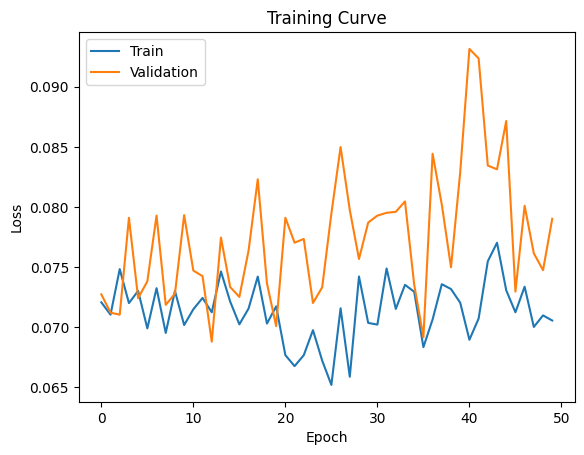

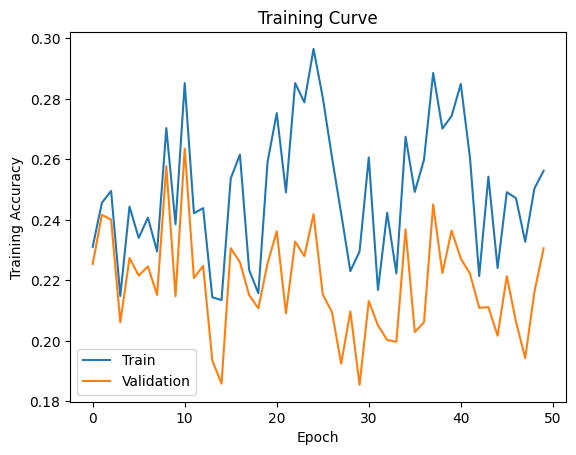

Final Training Accuracy: 0.25622360748039413
Final Validation Accuracy: 0.23061470470068302


In [ ]:
model = RNN(50, 128, 13, 'RNN', vectors)
train(model, train_loaders, val_loaders, batch_size = batch_size, num_epochs = 50, learning_rate = 0.01)

Epoch Number: 0


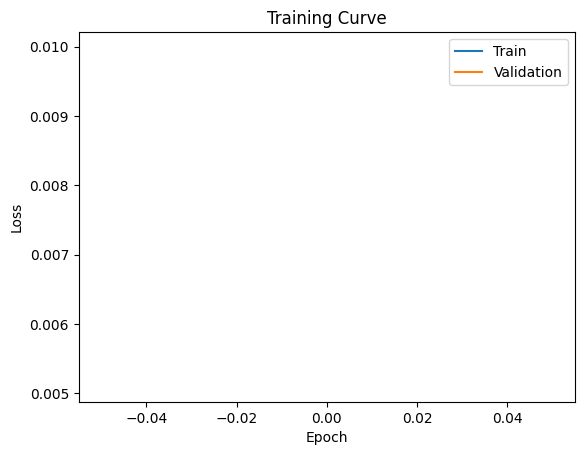

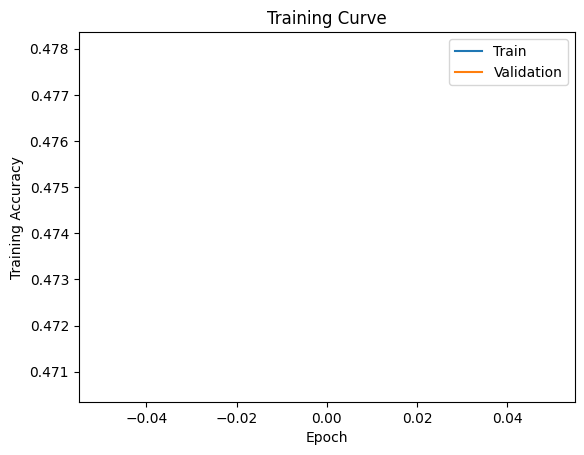

Final Training Accuracy: 0.4707129872752979
Final Validation Accuracy: 0.4779959377115775


In [ ]:
##### Deep LSTM #####
deep_lstm = Deep_LSTM(input_size = 50, hidden_size = 256, num_class = 3, num_layers = 3, name = 'Deep_LSTM', vectors = vectors)
train(deep_lstm, train_loaders, val_loaders, batch_size = batch_size, num_epochs = 1, learning_rate = 0.01)

In [ ]:
deep_lstm = Deep_LSTM(input_size = 50, hidden_size = 128, num_class = 3, num_layers = 3, name = 'Deep_LSTM', vectors = vectors)
train(deep_lstm, train_loaders, val_loaders, batch_size = batch_size, num_epochs = 200, learning_rate = 0.01)

## Baseline Model:

**Support Vector Machine (SVM):** (`Pandas` library)

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score

def train_svm_model(train_data, train_label, val_data, val_label, num_epochs, dataset):
  #create an SVM model
  svm_model = svm.SVC(kernel = 'linear', C = 0.001)

  # decide whether the dataset is train/val
  if(dataset == 'val'):
    train_data = val_data
    train_label = val_label

  # Lists to store training curve data
  epochs = []
  train_accuracy = []

  # Train the model and track the training curve
  for epoch in range(num_epochs):
    #train the bsaeline model (x_train, y_train)
    svm_model.fit(train_data, train_label)

    # Make predictions on the training data
    train_predictions = svm_model.predict(train_data)

    # Calculate accuracy on the training data
    train_acc = accuracy_score(train_label, train_predictions)

    # Append epoch number and accuracy to the lists
    epochs.append(epoch + 1)
    train_accuracy.append(train_acc)

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_acc:.4f}")

  # Plot the training curve
  plt.plot(epochs, train_accuracy)
  plt.title('Validation Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  return svm_model

In [ ]:
train_embedding_list = []
val_embedding_list = []
train_label_list = []
val_label_list = []

for group in train_data:  # list of tensors
  for tensor in group:  # each tensor within the group
    zero_tensor = torch.zeros(1, 50)
    for i in range(len(tensor)):  # iterate through each page number
      word_embedding = vectors[tensor[i]]  # get corresponding word embedding
      zero_tensor += word_embedding  # get the combined word embedding
    zero_tensor = zero_tensor / len(tensor)
    train_embedding_list.append(zero_tensor)
print(len(train_embedding_list))

for group in val_data:  # list of tensors
  for tensor in group:  # each tensor within the group
    zero_tensor = torch.zeros(1, 50)
    for i in range(len(tensor)):  # iterate through each page number
      word_embedding = vectors[tensor[i]]  # get corresponding word embedding
      zero_tensor += word_embedding  # get the combined word embedding
    zero_tensor = zero_tensor / len(tensor)
    val_embedding_list.append(zero_tensor)
print(len(val_embedding_list))

for group in train_label:  # iterate through every group of label
  for label in group:  # iterate every label
    train_label_list.append(label)
print(len(train_label_list))

for group in val_label:  # iterate through every group of label
  for label in group:  # iterate every label
    val_label_list.append(label)
print(len(val_label_list))

train_label_array = np.vstack(train_label_list)
val_label_array = np.vstack(val_label_list)
print(len(train_label_array))

train_embedding_array = np.vstack(train_embedding_list)
val_embedding_array = np.vstack(val_embedding_list)
print(len(train_embedding_array))

9902
1477
9902
1477
9902
9902


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [1/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [2/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [3/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [4/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [5/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [6/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [7/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [8/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [9/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [10/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [11/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [12/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [13/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [14/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [15/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [16/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [17/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [18/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [19/20], Train Accuracy: 0.5344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [20/20], Train Accuracy: 0.5344


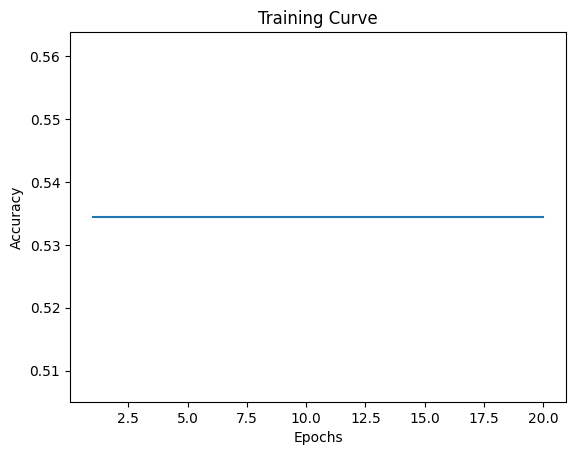

In [ ]:
svm_model = train_svm_model(train_embedding_array, train_label_array, val_embedding_array, val_label_array, num_epochs = 20, dataset='train')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [1/20], Train Accuracy: 0.4868
Epoch [2/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [3/20], Train Accuracy: 0.4868
Epoch [4/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [5/20], Train Accuracy: 0.4868
Epoch [6/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [7/20], Train Accuracy: 0.4868
Epoch [8/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [9/20], Train Accuracy: 0.4868
Epoch [10/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [11/20], Train Accuracy: 0.4868
Epoch [12/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [13/20], Train Accuracy: 0.4868
Epoch [14/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [15/20], Train Accuracy: 0.4868
Epoch [16/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [17/20], Train Accuracy: 0.4868
Epoch [18/20], Train Accuracy: 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [19/20], Train Accuracy: 0.4868
Epoch [20/20], Train Accuracy: 0.4868


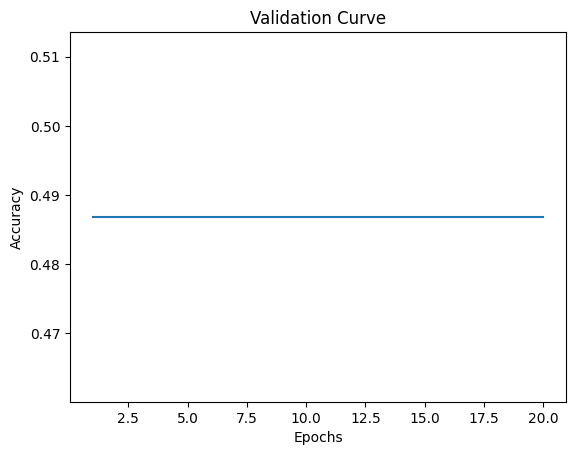

In [ ]:
svm_model = train_svm_model(train_embedding_array, train_label_array, val_embedding_array, val_label_array, num_epochs = 20, dataset='val')

## Final Testing:

Test with Baseline model (SVM):

Test with Deep learning model and get accuracy:

Promote user input:

In [ ]:
# Combine convertion for one line statement
def convert(msg):
  # put into a dataframe
  df_sentence = pd.DataFrame([msg], columns=["sentence"])

  # Tokenize
  df_sentence['sentence'] = df_sentence['sentence'].astype(str)  # Convert 'sentence' column to string
  df_sentence['tokenized_sentences'] = df_sentence['sentence'].apply(lambda x: word_tokenize(x))  # New column 'tokenized_sentences' containing tokenized sentences
  subdf_sentence = df_sentence[["tokenized_sentences"]]  # extract the labels and tokenized sentences into a new dataframe, subdf

  # Remove punctuations
  subdf_sentence['perfect_tokens'] = subdf_sentence['tokenized_sentences'].apply(lambda tokens: [remove_punctuation(token) for token in tokens])

  # Remove empty strings from the tokenized sentences
  subdf_sentence['perfect_tokens'] = subdf_sentence['perfect_tokens'].apply(lambda tokens: [token for token in tokens if token])

  # convert to lowercase
  subdf_sentence['perfect_tokens'] = subdf_sentence['perfect_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

  return subdf_sentence

In [ ]:
def process_step(dataframe):
   print("Processing the next step...")

   # match the keys
   model_path = get_model_name("Deep_LSTM", batch_size = 256, learning_rate = 0.01, epoch = 0)
   state = torch.load(model_path)
   deep_lstm.load_state_dict(state)

   # create the list
   tokens_ = []
   tokens = []

   # Extract the first row from the DataFrame as a list of tokens
   first_row_tokens = dataframe['perfect_tokens'].iloc[0]

   cnt = 0
   # Append each token from the first row to the result_list one by one from the start
   for token in first_row_tokens:
      tokens_.append(token)
      cnt += 1

   # pair the tokens with the vocab list and return the number
   for idx in range(cnt):
    tokens.append(vocab[tokens_[idx]])

   # convert into tensor
   tokens_tensor = torch.LongTensor([tokens])  # create a tensor
   with torch.no_grad():  # since not training, we ensure there is no gradient computed
       pred = deep_lstm(tokens_tensor)  # contains the output of the model

   # calc the prediction
   sentiment = torch.softmax(pred, dim=1)[0][1].item()  # applying the softmax function along the tensor's dimension 1
   if(sentiment > 0.3):
    result = "Positive"
   elif(sentiment < -0.3):
    result = "Negative"
   else:
    result = "Neutral"
   print("the sentiment predicted for this message is: ", result, sentiment)

In [ ]:
# Choose to proceed
def choose(dataframe):
  user_choice = input("Do you want to proceed? (Yes/No): ").lower()

  if user_choice == 'yes':
    print("You chose 'Yes'.")
    process_step(dataframe)  # Call the function for the next step
  elif user_choice == 'no':
    print("You chose 'No'. Exiting.")
  else:
    print("Invalid choice. Please enter 'Yes' or 'No'.")
    choose(dataframe)  # promote again

In [ ]:
# get the user input
user_input = input("Enter a string-type sentence: ")

# convert to suitable type store back into a dataframe
dataframe = convert(user_input)

#print(dataframe)  # testing
print("Your entered sentence is: ", user_input)

# choose to proceed or not
choose(dataframe)

Enter a string-type sentence: i love
Your entered sentence is:  i love
Do you want to proceed? (Yes/No): yes
You chose 'Yes'.
Processing the next step...
the sentiment predicted for this message is:  Positive 0.4513462781906128


In [ ]:
# given msg
msg = user_input
# match the keys
model_path = get_model_name("RNN", batch_size = 256, learning_rate = 5e-4, epoch = 19)
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# store into dataframe
# Create a DataFrame with the input sentence in one column
df_sentence = pd.DataFrame([msg], columns=["sentence"])
df_sentence

,sentence
0,Machine Learning is Cool!


In [ ]:
# Tokenize
df_sentence['sentence'] = df_sentence['sentence'].astype(str)  # Convert 'sentence' column to string
df_sentence['tokenized_sentences'] = df_sentence['sentence'].apply(lambda x: word_tokenize(x))  # New column 'tokenized_sentences' containing tokenized sentences
subdf_sentence = df_sentence[["tokenized_sentences"]]  # extract the labels and tokenized sentences into a new dataframe, subdf
subdf_sentence  # visualize first three lines of subdf dataframe

,tokenized_sentences
0,"[Machine, Learning, is, Cool, !]"


In [ ]:
# Remove punctuations
subdf_sentence['perfect_tokens'] = subdf_sentence['tokenized_sentences'].apply(lambda tokens: [remove_punctuation(token) for token in tokens])
subdf_sentence

,tokenized_sentences,perfect_tokens
0,"[Machine, Learning, is, Cool, !]","[Machine, Learning, is, Cool, ]"


In [ ]:
# Remove empty strings from the tokenized sentences
subdf_sentence['perfect_tokens'] = subdf_sentence['perfect_tokens'].apply(lambda tokens: [token for token in tokens if token])
subdf_sentence

,tokenized_sentences,perfect_tokens
0,"[Machine, Learning, is, Cool, !]","[Machine, Learning, is, Cool]"


In [ ]:
# convert to lowercase
subdf_sentence['perfect_tokens'] = subdf_sentence['perfect_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
subdf_sentence = subdf_sentence['perfect_tokens']
subdf_sentence

0    [machine, learning, is, cool]
Name: perfect_tokens, dtype: object